In [8]:
from uflowlib import particle_trace as pt
import uflowlib.vectormath as v
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
%matplotlib inline

matplotlib.rcParams['figure.figsize'] = [15,15]

Particle Tracing
================

Let's run the particle tracing code through the ringer.

The OGL Particle Tracing class rakes a bunch of particles through a channel using GLSL for hardware acceleration. Let's test its various features. For now, we'll use the velocity field in /home/keegan/repo/particle-track.



In [2]:
filename = "/home/keegan/repo/particle-track/vecdata.def"

Forward Advection
-----------------

First, set up a translation matrix that positions the particles within the channel, then create a tracer with the appropriate parameters.

In [3]:
mat = v.translation_matrix(0.01, 0, 0)
tracer = pt.OGLParticleTracer(filename = filename, affine=mat)

NoSectionError: No section: 'vectortex3d'

Step particles to the end of the channel. The tracer should generate the shader at this stage.

In [4]:
for i in range(598):
    tracer.step_particles()

NameError: name 'tracer' is not defined

Now we fetch the result from the GPU and visualize it:

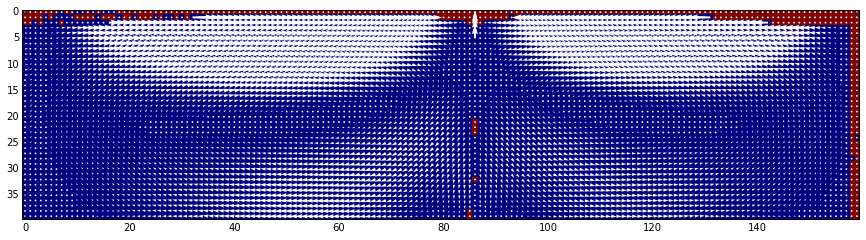

In [5]:
d = tracer.get_displacements()
plt.imshow((d[::-5, ::5, 1] == 0)*100, interpolation='nearest')
plt.quiver(d[::-5, ::5, 1], d[::5,::5,2], color='w')

Reverse Advection
-----------------



Now we try the same thing in reverse; for each endpoint, rake particles back to the beginning. This means our particles need to start at the end of the channel.

In [6]:
mat = v.translation_matrix(5.99, 0, 0)
rtracer = pt.OGLParticleTracer(filename = filename, affine=mat, direction=-1)
for i in range(598):
    rtracer.step_particles()
dr = rtracer.get_displacements()

/usr/local/lib/python3.4/dist-packages/IPython/kernel/__main__.py:5: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.4/dist-packages/IPython/kernel/__main__.py:5: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.4/dist-packages/IPython/kernel/__main__.py:5: RuntimeWarning: invalid value encountered in greater


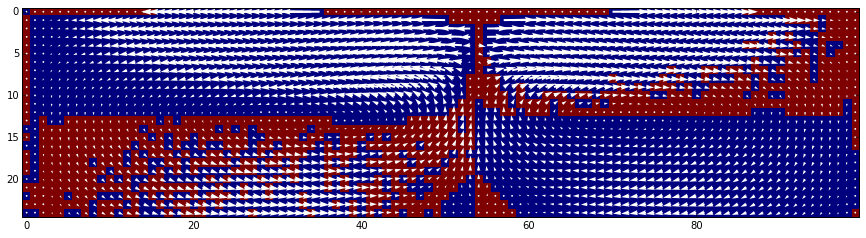

In [50]:
r = np.array((.142,))
m = np.array((-.0657,))
r2 = np.array((1,))
m2 = np.array((-.75,))
plt.imshow(np.sqrt((dr[::-8, ::8, 1] - (np.floor((dr[::-8, ::8, 1] - m )/r*(2**13-1))/(2**13-1)*r+m))/dr[::-8, ::8, 1] + \
           (dr[::-8, ::8, 0] - (np.floor((dr[::-8, ::8, 0] - m2 )/r2*(2**13-1))/(2**13-1)*r2+m2))/dr[::-8, ::8, 0] ) > .02, interpolation='nearest')
plt.quiver(dr[::-8, ::8, 1], dr[::8,::8,2], color='w')

Advection Maps
==============
Besides using the results as numpy arrays, we can use uflowlib's advection map functionality. This enables us to visualize the results more intuitively than using quiver plots; eg, by visualizing a cross-section of the resulting flow.

In [15]:
from uflowlib import advection as adv
from imp import reload
import pyglet as pg
#win = pg.window.Window(width=800, height=200)

In [19]:
reload(adv)
pcafactory = adv.OGLPCAFactory()
pcafactory.load("maps/pca/")

In [4]:
a = pcafactory.get_job_id(parameters = {"Re": 20, "y": 0, "D": .6, "h":1})
a

(1142, {'D': 0.6, 'Re': 20, 'h': 0.25, 'y': 0})

In [5]:
pcafactory.get_params_from_id(1098)

{'D': 0.6, 'Re': 20.0, 'h': 0.25, 'y': 0.22}

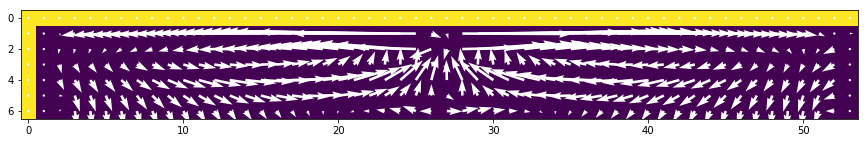

In [9]:
map = pcafactory.get_map(100)
dr = map.array()
plt.imshow((dr[::-15, ::15, 1] == 0), interpolation='nearest')
plt.quiver(dr[::-15, ::15, 1], dr[::15,::15,2], color='w')

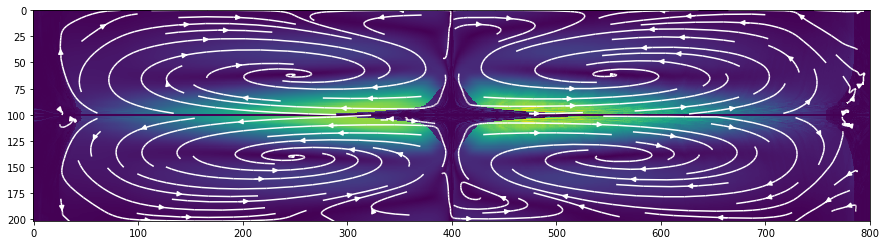

In [10]:
x = np.linspace(0,801,801)
y = np.linspace(0,202,101*2)
dz = np.vstack((dr[:,:,1:3], np.append(dr[::-1,:,1:2], -dr[::-1,:,2:3], axis=2)))
plt.streamplot(x,y,dz[:,:,0],dz[:,:,1], color='w')
plt.imshow(np.sqrt(dz[:,:,0]**2 + dz[:,:,1]**2))

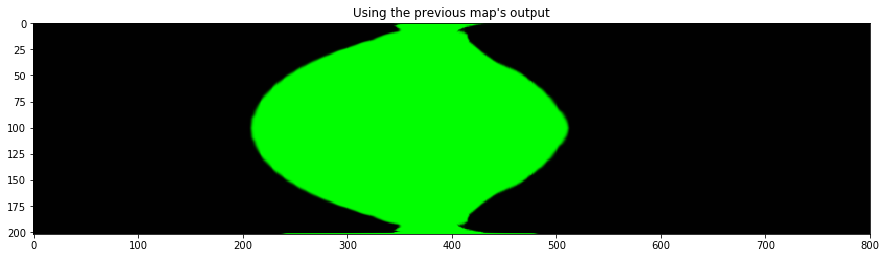

In [20]:
from uflowlib import globjects as glo
map = pcafactory.get_map(-1)
images = []
inletcolors = (0,0,0,0,1,0,0,0,0)
inletstreams = (.3, .6,)
images.append(map.render_to_texture(inletcolors=inletcolors,inletstreams=inletstreams))
n = map
Pe = 10**10
for i in range(10):
    images.append(map.render_to_texture(images[-1], sigma=(1.0/Pe))) # array of textures
    n = n.append(map) # appending advection maps

arr = images[-1].read_pixels()
plt.figure()
plt.imshow(np.vstack((arr[::-1,:,:], arr)))
plt.title("Using the previous map's output")

# i = n.render(inletcolors=inletcolors,inletstreams=inletstreams, sigma=(1.0/Pe))
# plt.figure()
# plt.imshow(np.vstack((i[::-1,:,:], i)))
# plt.title("Creating a new advection map")

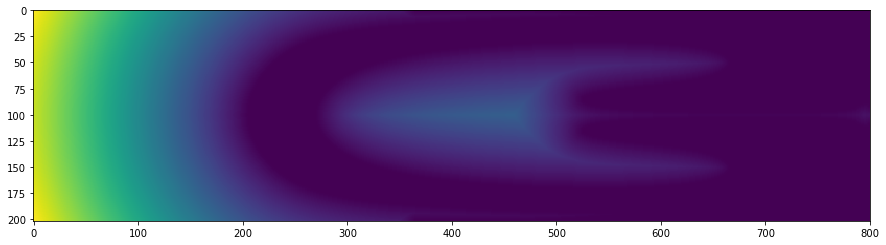

In [14]:
result = np.vstack((arr[::-1,:,1] , arr[:,:,1]))

#Binary threshold
b = result < .5
plt.imshow(result)
from scipy import ndimage
d = np.float32(ndimage.distance_transform_edt(b))
plt.imshow(d)

In [15]:
d = np.append(d.reshape(d.shape[0], d.shape[1],1), d.reshape(d.shape[0], d.shape[1],1), axis=2)
d = np.append(d, d, axis=2)
t = glo.Texture(d, dims = (d.shape[1], d.shape[0]))
a = t.read_pixels()

In [16]:
a[0,0:4]

array([[ 224.51057434,  224.51057434,  224.51057434,  224.51057434],
       [ 223.57995605,  223.57995605,  223.57995605,  223.57995605],
       [ 222.64994812,  222.64994812,  222.64994812,  222.64994812],
       [ 221.72055054,  221.72055054,  221.72055054,  221.72055054]], dtype=float32)

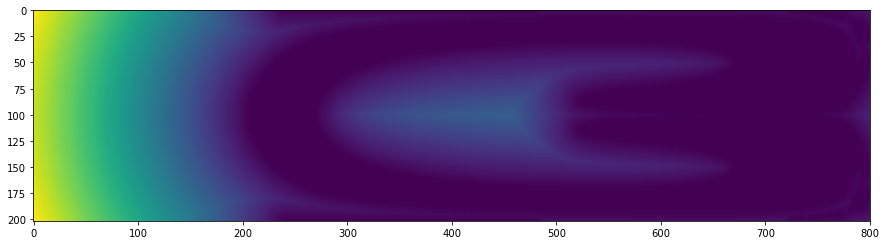

In [17]:
plt.imshow(a[:,:,1])

In [18]:
from uflowlib.globjects import Texture
t = Texture.from_file(open('/home/keegan/repo/uflow/maps/rounded/D0.375_y0.000.ft', 'rb'))

IOError: [Errno 2] No such file or directory: '/home/keegan/repo/uflow/maps/rounded/D0.375_y0.000.ft'

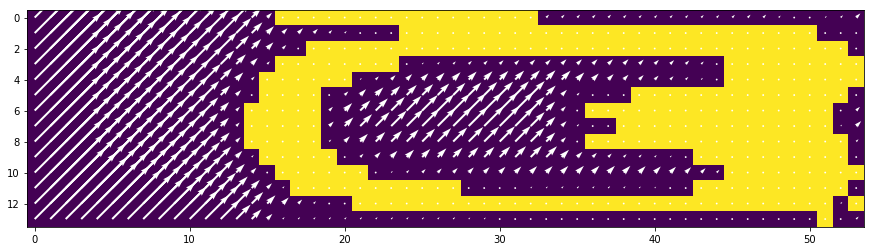

In [19]:
a = adv.AdvectionMap(tex = t)
dr = a.array()
plt.imshow((dr[::-15, ::15, 0] == 0), interpolation='nearest')

plt.quiver(dr[::-15, ::15, 0], dr[::15,::15,1], color='w')


In [ ]:
a2 = pcafactory.get_map(pcafactory.get_job_id(parameters = {'Re': 20, 'y': 0, 'D':.375, 'h':.25})[0], cpu=True)
#dr = a2.array()
#plt.imshow((dr[::-15, ::15, 1] == 0), interpolation='nearest')

#plt.quiver(dr[::-15, ::15, 1], dr[::15,::15,2], color='w')

In [ ]:

print(type(pcafactory._dims[1]))